# Data extraction

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import os
from tqdm import tqdm
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import time

# Twitter API library
import tweepy
# Binance API library
from binance.client import Client
# Google Trends API library
from pytrends.request import TrendReq

# My module
import my_email
import config

## Twitter extraction

This section aims to retrieve tweets from the *Twitter API* using `tweepy` library and then make a first round of cleaning them (e.g. *drop duplicates*, *sort it* by date) and stored them in a csv.

In [5]:
# Hiding secret API keys in Environment Variables
consumer_key = config.CONSUMER_KEY
consumer_secret = config.CONSUMER_SECRET

access_token = config.ACCESS_TOKEN
access_token_secret = config.ACCESS_TOKEN_SECRET

In [6]:
query = 'Bitcoin OR BTC OR #Bitcoin OR #BTC OR $Bitcoin OR $BTC'

In [7]:
# Check access to the API
auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)
api = tweepy.API(auth)
if(api.verify_credentials):
    print("Access granted :)")
else:
    print("Access denied :(")

Access granted :)


Definning some functions:

In [8]:
# Functions

def connect_to_twitter_OAuth2(consumer_key=consumer_key, consumer_secret=consumer_secret):
    """Sets a connection to the twitter API.
    
    Parameters
    ----------
    consumer_key : set by default
    consumer_secret : set by default
    """
    auth = tweepy.AppAuthHandler(consumer_key, consumer_secret)
    api = tweepy.API(auth)
    return api


def retrieve_tweets(api, since_id=None, max_id=None):
    """
    It returns a twitter object with 100 tweets of a specific api response.
    
    Parameters
    ----------
    api : api connection (required)
    since_id : if given, it returns tweets with an ID greater than that (newer)
    max_id : if given, it returns tweets with an ID less or equal than that (older) (max. 7 days prior)
    """
    return api.search(q=query,
                      lang='en',
                      result_type='mixed',
                      count=100,
                      since_id=since_id,
                      max_id=max_id,
                      tweet_mode='extended')


def extract_tweet_atributes(tweet_object):
    """It returns a Pandas DataFrame with a tweet per row and its attributes per column."""
    
    tweets_list = []
    
    for tweet in tweet_object:
        # Iterates over each tweet and gets its attributes
        tweet_id = tweet.id   # Unique tweet identifier
        text = tweet.full_text   # Sring, text of the tweet
        screen_name = tweet.user.screen_name   # String, username
        followers = tweet.user.followers_count   # Number of followers
        retweet_count = tweet.retweet_count   # Number of retweets
        favorite_count = tweet.favorite_count   # Number of favorites
        created_at = tweet.created_at   # UTC time tweet created
        source = tweet.source   # Utility used to post the tweet
        # Append attributes to list
        tweets_list.append({'tweet_id':tweet_id,
                            'text':text, 
                            'screen_name':screen_name,
                            'followers':followers,
                            'retweet_count':retweet_count, 
                            'favorite_count':favorite_count, 
                            'created_at':created_at, 
                            'source':source})
    # Creates a DataFrame
    df = pd.DataFrame(tweets_list, columns=['tweet_id',
                                            'text',
                                            'screen_name',
                                            'followers',
                                            'retweet_count',
                                            'favorite_count', 
                                            'created_at',
                                            'source'])
    return df


def first_cleaning(df):
    """It returns a DataFrame after dropping duplicates (subset=['tweet_id']) and sorting it (by='tweet_id')
    
    Parameters
    ----------
    df : Pandas DataFrame to clean.
    """
    df_no_dup = df.drop_duplicates(subset=['tweet_id'], ignore_index=True)
    cleaned_df = df_no_dup.sort_values(by='tweet_id', ignore_index=True)
    return cleaned_df


**API rate limits:** Maximum of 450 requests per 15 minutes. Endpoint: *Recent Search*

In [9]:
# Main functions

def main_retrieval(file_path, last_id=None):
    """
    Main retrieval function.
    It makes 450 requests.
    It saves a DataFrame to a csv in a given path.
    
    Returns
    -------
    + Last tweet id.
    + DataFrame length
    
    Parameters
    ----------
    file_path : file where the DataFrame will be stored (append mode)
    last_id : if given, it retrieves tweets only with a greter ID (older)
    """
    # Set a connection to the api
    api = connect_to_twitter_OAuth2()
    # Set some required variables
    number_of_requests = 450
    dfs = []
    # Main loop
    for i in tqdm(range(number_of_requests)):
        
        crypto_tweets = retrieve_tweets(api, since_id=last_id)
        df = extract_tweet_atributes(crypto_tweets)
        # Set a new last_id. Next iteration starts taking tweets from it on
        last_id = df['tweet_id'].max()
        dfs.append(df)

    df = pd.concat(dfs, ignore_index=True)
    df = first_cleaning(df)
    last_id = df['tweet_id'].max()
    # Saves df to a csv in the file_path, ignoring index, appending it, and not writting column names each time
    df.to_csv(file_path, sep=',', index=False, mode='a', header=False)

    return last_id, len(df)



def long_term_retrieval(file_path, iterations=25, last_id=None):
    """
    It aims to be retrieving tweets for a long period, 12-24 hours.
    
    Parameters
    ----------
    file_path : file where the DataFrame will be stored (append mode).
    iterations : number of main_retrieval function calls. 25 iterations -> 10 hours period.
    last_id : if given, it retrieves tweets only with a greter ID (older).
    """
    lap = 0
    while lap <= iterations:
        # Try to retrieve tweets or sends an email if it cannot. It does not break the loop
        try:
            # Set the next last_id and the length of the DataFrame that just added to the csv
            last_id, length = main_retrieval(file_path=file_path, last_id=last_id)
            print(f'{length} new rows added to the csv.')
        except:
            print('Error!')
            my_email.error_email()
        # Release the counter and break the loop if necessary
        lap += 1
        if lap > iterations:
            break
        print(f'{(iterations + 1) - lap} laps to go.')
        # Check if it's the last lap
        if lap == iterations:
            my_email.last_lap_reminder()
        # Checks the battery and sends an email if its low
        if my_email.check_battery() < 20:
            my_email.warning()            
        # Time info
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print(f'Getting some sleep @ {current_time}...')
        # Getting some sleep til next main retrieval
        time.sleep(20 * 60)
        print('*' * 50)
    print('Done :D\nEnjoy it!')

In [10]:
# Path where the set of tweets will be stored to play with them
file_path = 'C:/Users/Javi/Desktop/cryptocurrency_predictor/data/twitter/raw_tweets.csv'

In [11]:
time.sleep(10*60)

In [ ]:
long_term_retrieval(file_path, iterations=3, last_id=largest)

100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [04:30<00:00,  1.67it/s]


794 new rows added to the csv.
3 laps to go.
Getting some sleep @ 00:25:55...
**************************************************


100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [04:38<00:00,  1.62it/s]


671 new rows added to the csv.
2 laps to go.
Getting some sleep @ 00:50:34...
**************************************************


100%|████████████████████████████████████████████████████████████████████████████████| 450/450 [04:41<00:00,  1.60it/s]


658 new rows added to the csv.
1 laps to go.
Getting some sleep @ 01:15:19...


### Truncated tweets
Texts over 140 characters are truncated. There could be a solution, adding `tweet_mode='extended'` parameter when calling my "retrive_tweets" function. <br>
Let's see it in action!

AND IT WORKS!!! We got the full text of the tweet! Take that Twitter!
It doesn't work for retweets though.

### First look at the data!

In [2]:
file_path = 'C:/Users/Javi/Desktop/cryptocurrency_predictor/data/twitter/raw_tweets.csv'
columns = ['tweet_id',
           'text',
           'screen_name',
           'followers',
           'retweet_count',
           'favorite_count', 
           'created_at',
           'source']

data = pd.read_csv(file_path, names=columns)

In [3]:
print(data.info())
data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1553885 entries, 0 to 1553884
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   tweet_id        1553885 non-null  int64 
 1   text            1553885 non-null  object
 2   screen_name     1553885 non-null  object
 3   followers       1553885 non-null  int64 
 4   retweet_count   1553885 non-null  int64 
 5   favorite_count  1553885 non-null  int64 
 6   created_at      1553885 non-null  object
 7   source          1529871 non-null  object
dtypes: int64(4), object(4)
memory usage: 94.8+ MB
None


,tweet_id,text,screen_name,followers,retweet_count,favorite_count,created_at,source
1553880,1373427943234473993,We have exactly 23H to close this in a bullish...,crypto8260,261,0,0,2021-03-21 00:15:13,Twitter for Android
1553881,1373427943318360067,@elliotrades $vxv vectorspace ai\n\nSo what's ...,Mrcryptopia,354,0,0,2021-03-21 00:15:13,Twitter for Android
1553882,1373427944991956993,RT @ZerrBenz: BTCST Community AIRDROP Event\n\...,Lebr00n,401,22,0,2021-03-21 00:15:13,Twitter for Android
1553883,1373427945109340164,#AffiliateMarketing #crypto #cryptocurrency #m...,bmurphypointman,69733,0,0,2021-03-21 00:15:13,ContentStudio.io
1553884,1373427948536131584,Do you see what I see ?? for BITSTAMP:BTCUSD ...,bitcoinagile,56355,0,0,2021-03-21 00:15:14,bitcoinagile


In [4]:
largest = data['tweet_id'].max()

We ended up with over 1,500,000 tweets extracted from the Twitter API throughout 4 weeks (28 days), from 21/02/2021 to 21/03/2021. Let's see how much meaningful info we can get from all of this.

Head over to the next notebook!

## Crypto extraction

We will use Binance API to retrieve Bitcoin close prices.

In [2]:
# Defining some constants
symbol = 'BTCUSDT'
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 950
start_time = '1 Jan 2021'

binance_client = Client(api_key=config.API_KEY, api_secret=config.API_SECRET)

In [3]:
### Defining some functions
def minutes_of_new_data(symbol, kline_size, data):
    """Set a new, old dates for the crypto extraction to retrieve new data."""
    if len(data) > 0:
        old = parser.parse(data["timestamp"].iloc[-1])
    else:
        old = datetime.strptime(start_time, '%d %b %Y')
    new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')

    return old, new


def get_all_binance(symbol, kline_size, save=False):
    """It gets historical btc/usd prices from the binance API
    
    Parameters
    ----------
    symbol : str. Capital letters
    kline_size : str. Period of the prices in return
    save : bool
    """
    filename = 'C:/Users/Javi/Desktop/cryptocurrency_predictor/data/crypto/%s_%s_data.csv' % (symbol, kline_size)

    if os.path.isfile(filename):
        data_df = pd.read_csv(filename)

    else:
        data_df = pd.DataFrame()

    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df)

    delta_min = (newest_point - oldest_point).total_seconds() / 60
    available_data = math.ceil(delta_min / binsizes[kline_size])

    if oldest_point == datetime.strptime(start_time, '%d %b %Y'):
        print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else:
        print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol,
                                                                                                      available_data,
                                                                                                      kline_size))

    klines = binance_client.get_historical_klines(symbol,
                                                  kline_size,
                                                  oldest_point.strftime("%d %b %Y %H:%M:%S"),
                                                  newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines,
                        columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av',
                                 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else:
        data_df = data

    data_df.set_index('timestamp', inplace=True)
    if save:
        data_df.drop(['quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'], axis=1).to_csv(filename)

    print('All caught up..!')
    # return data_df.drop(['quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore'], axis=1)

In [4]:
get_all_binance(symbol=symbol, kline_size='1m', save=True)

All caught up..!


In [5]:
get_all_binance(symbol=symbol, kline_size='5m', save=True)

All caught up..!


In [6]:
get_all_binance(symbol=symbol, kline_size='1h', save=True)

All caught up..!


### First look at the data

In [11]:
btc_h = pd.read_csv('C:/Users/Javi/Desktop/cryptocurrency_predictor/data/crypto/BTCUSDT_1h_data.csv', parse_dates=[0])

btc_h.info()
btc_h.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2513 entries, 0 to 2512
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   2513 non-null   datetime64[ns]
 1   open        2513 non-null   float64       
 2   high        2513 non-null   float64       
 3   low         2513 non-null   float64       
 4   close       2513 non-null   float64       
 5   volume      2513 non-null   float64       
 6   close_time  2513 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 137.6 KB


,timestamp,open,high,low,close,volume,close_time
0,2021-01-01 00:00:00,28923.63,29031.34,28690.17,28995.13,2311.811445,1609462799999
1,2021-01-01 01:00:00,28995.13,29470.00,28960.35,29409.99,5403.068471,1609466399999
2,2021-01-01 02:00:00,29410.00,29465.26,29120.03,29194.65,2384.231560,1609469999999


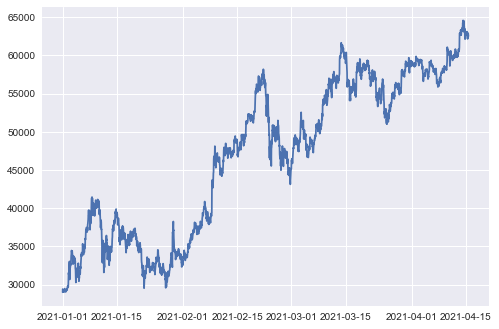

In [13]:
plt.plot(btc_h['timestamp'], btc_h['close'])

## Google Trends Extraction

We are using `pytrends`, Google Trends unofficial library for python in order to retrieve Google trends on Bitcoin

In [14]:
pytrends = TrendReq(hl='en-US', tz=360)
keywords = ['bitcoin']

In [15]:
btc_trends = pytrends.get_historical_interest(keywords,
                                              year_start=2021, month_start=2, day_start=1, hour_start=0,
                                              year_end=2021, month_end=4, day_end=1, hour_end=0,
                                              cat=0, geo='', gprop='', sleep=60
                                             )

The request failed: Google returned a response with code 500.


As dates are in US CST (UTC - 6) by default, in order to match dates from our twitter extraction data, we need to make the query from 20-02-2021 18:00:00 to 20-03-2021 18:00:00

In [21]:
btc_trends.head()

,bitcoin
date,
2021-02-21 00:00:00,72
2021-02-21 01:00:00,72
2021-02-21 02:00:00,72
2021-02-21 03:00:00,73
2021-02-21 04:00:00,75


In [17]:
btc_trends.drop('isPartial', axis=1, inplace=True)
# Dates are in US CST (UTC - 6) by default
btc_trends.index = pd.to_datetime(btc_trends.index) + timedelta(hours=6)
btc_trends.info()
btc_trends

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1352 entries, 2021-02-01 06:00:00 to 2021-03-29 06:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   bitcoin  1352 non-null   int32
dtypes: int32(1)
memory usage: 15.8 KB


,bitcoin
date,
2021-02-01 06:00:00,78
2021-02-01 07:00:00,73
2021-02-01 08:00:00,71
2021-02-01 09:00:00,70
2021-02-01 10:00:00,73
...,...
2021-03-29 02:00:00,68
2021-03-29 03:00:00,66
2021-03-29 04:00:00,63


In [18]:
btc_trends = btc_trends[(btc_trends.index >= '2021-02-21') & (btc_trends.index <= '2021-03-22')]

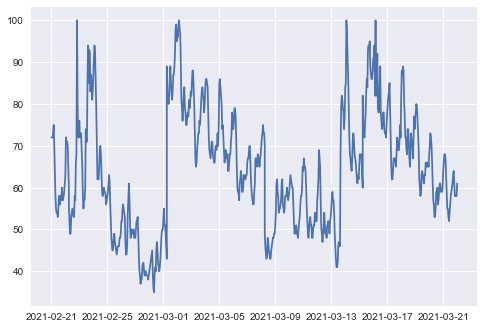

In [19]:
plt.plot(btc_trends['bitcoin'])

In [20]:
btc_trends.to_csv('C:/Users/Javi/Desktop/cryptocurrency_predictor/data/google_trends/bitcoin_trends.csv')